In [40]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

In [41]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense
from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

In [42]:

class EMRIS(Layer):
    def __init__(self, ris, scene):

        super().__init__()

        # RIS object for this EMRIS
        self.ris = ris

        # Scene to compute paths
        self.scene = scene

        # Trainable phase profile initialized to zero
        self.phase_profile = tf.Variable(
            tf.zeros_like(self.ris.phase_profile.values),
            trainable=True,
            name="phase_profile"
        )

        # Trainable amplitude profile initialized to one with a constraint
        self.amplitude_profile = tf.Variable(
            tf.ones_like(self.ris.amplitude_profile.values),
            trainable=True,
            constraint=lambda x: tf.abs(x),
            name="amplitude_profile"
        )

    def call(self, inputs):

        scene = inputs

        def to_db(x):
            return 10 * tf.math.log(x) / tf.math.log(10.0)

        # Normalize amplitude profile to ensure average power of one
        self.ris.amplitude_profile.values = self.amplitude_profile / tf.sqrt(
            tf.reduce_mean(self.amplitude_profile ** 2, axis=[1, 2], keepdims=True)
        )

        # Set the trainable phase profile
        self.ris.phase_profile.values = self.phase_profile

        # Compute paths using the scene
        paths = scene.compute_paths()

        # Extract channel impulse response and remove unused dimensions
        a = tf.squeeze(paths.cir()[0])


        # Compute average path gain per RX
        if len(a.shape) >= 1:
         path_gain = to_db(tf.reduce_mean(tf.reduce_sum(tf.abs(a) ** 2, axis=-1)))
        else:
         path_gain = to_db(tf.reduce_mean(tf.abs(a) ** 2))

         return path_gain, a


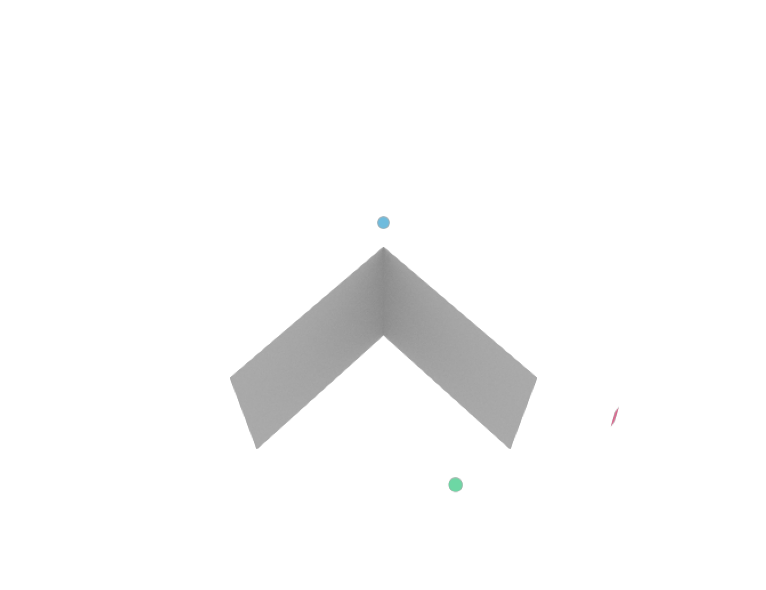

In [46]:
# Load scene consiting of a simple wedge
scene = load_scene(sionna.rt.scene.simple_wedge)
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter
tx = Transmitter("tx", position=[-10,10,0])
scene.add(tx)

# Place receivers
rx = Receiver("rx", position=[30,-15,0])
scene.add(rx)
# Place RIS
ris = RIS(name="ris",
          position=[40,10,0],
          num_rows=50,
          num_cols=50,
          num_modes=2,
          look_at=(tx.position+rx.position)/2) # Look in between TX and RX
scene.add(ris)

scene.add(Camera("cam",
                         position=[50,-50,130],
                         look_at=[0,0,0]))
scene.render(camera="cam", num_samples=512);


In [44]:
# Instantiate the EMRIS layer
emris = EMRIS(ris,scene)


path_gain,_ = emris(scene)


In [45]:
# Optimizer for training
optimizer = tf.keras.optimizers.Adam(0.5)

# Number of training iterations
num_iterations = 100

for i in range(num_iterations):
    # Use GradientTape for automatic differentiation
    with tf.GradientTape() as tape:
        # Call the EMRIS layer
        path_gain, a = emris((scene))
        # Define the loss function
        loss = -path_gain

    # Compute gradients with respect to the trainable variables
    grads = tape.gradient(loss, emris.trainable_variables)

    # Apply gradients to update the trainable variables
    optimizer.apply_gradients(zip(grads, emris.trainable_variables))

    # Log progress every 10 iterations
    if i % 10 == 0 or i == 0:
        print(f"Iteration {i} - Path Gain: {path_gain.numpy():.2f} dB")


Iteration 0 - Path Gain: -102.15 dB
Iteration 10 - Path Gain: -74.39 dB
Iteration 20 - Path Gain: -72.02 dB
Iteration 30 - Path Gain: -70.42 dB
Iteration 40 - Path Gain: -69.92 dB
Iteration 50 - Path Gain: -69.46 dB
Iteration 60 - Path Gain: -69.02 dB
Iteration 70 - Path Gain: -68.69 dB
Iteration 80 - Path Gain: -68.44 dB
Iteration 90 - Path Gain: -68.27 dB
